<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

In [1]:
import torch
import fastai as fastai
import fastai.vision.all as vision

from PIL import Image 
import numpy as np

In [ ]:
path = vision.untar_data(vision.URLs.BIWI_HEAD_POSE)
path.ls()

In [ ]:
path.ls()[0].ls().sorted(), path.ls()[2].ls().sorted()

get_image_files walks through all the directories and reads only images(like with extension .jpg, .jpeg etc)

In [4]:
img_files = vision.get_image_files(path).sorted()

In [ ]:
str(img_files[0])[:-7], f'{str(img_files[0])[:-7]}pose.txt'

In [6]:
def img2pose(img_file): return f'{str(img_file)[:-7]}pose.txt'

img2pose(img_files[8])

'/root/.fastai/data/biwi_head_pose/01/frame_00011_pose.txt'

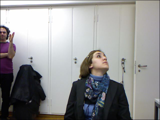

In [7]:
im = Image.open(img_files[2000])
im.to_thumb(h=160)

skip_header --> No. of lines to skip at the begining of the file

skip_footer --> No. of lines to skip at the end of the file

In [8]:
np.genfromtxt(img2pose(img_files[0])), np.genfromtxt(img2pose(img_files[0]), skip_header=3)

(array([[ 9.97978e-01,  2.72944e-02,  5.74071e-02],
        [-3.46956e-02,  9.90621e-01,  1.32163e-01],
        [-5.32613e-02, -1.33887e-01,  9.89564e-01],
        [ 5.19358e+01,  3.82631e+01,  8.81756e+02]]),
 array([ 51.9358,  38.2631, 881.756 ]))

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

#function to get the coordinates of centre point of face
def get_ctr(img_file):
  ctr = np.genfromtxt(img2pose(img_file), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return torch.tensor([c1,c2])

In [10]:
get_ctr(img_files[9])

tensor([350.7417, 262.8703], dtype=torch.float64)

get_y takes the image names from get_image_files function passed to get_items

But if get_x is used instead of get_items, then the source path given to datasets attribute of data block is passed to get_y


Splitting based on the parent name of the folder, the folder name is just numbers like --01, 02, 03 .....

So if the condition parent folder name == 13 evaluates to True, then it is a validation set, else it is given to the training set.



In [11]:
db = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.PointBlock),
    get_items=vision.get_image_files,
    get_y=get_ctr,
    splitter=vision.FuncSplitter(lambda x: x.parent.name == '13'),
    batch_tfms=[*vision.aug_transforms(size=(240, 320)),
                vision.Normalize.from_stats(*vision.imagenet_stats)]
)

In [12]:
db.datasets(path)

(#15678) [(PILImage mode=RGB size=640x480, TensorPoint([[342.6052, 228.2558]])),(PILImage mode=RGB size=640x480, TensorPoint([[341.0638, 222.3987]])),(PILImage mode=RGB size=640x480, TensorPoint([[369.8061, 230.0068]])),(PILImage mode=RGB size=640x480, TensorPoint([[381.9967, 243.7213]])),(PILImage mode=RGB size=640x480, TensorPoint([[373.8940, 237.1484]])),(PILImage mode=RGB size=640x480, TensorPoint([[361.5940, 223.1704]])),(PILImage mode=RGB size=640x480, TensorPoint([[310.8475, 244.1320]])),(PILImage mode=RGB size=640x480, TensorPoint([[333.8764, 261.5651]])),(PILImage mode=RGB size=640x480, TensorPoint([[356.6263, 222.7979]])),(PILImage mode=RGB size=640x480, TensorPoint([[337.9678, 230.1450]]))...]

In [ ]:
db.summary(path)

In [14]:
dls = db.dataloaders(path, bs=32)

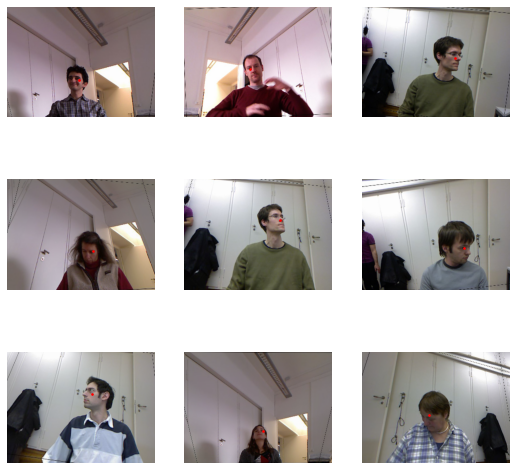

In [15]:
dls.show_batch()

In [16]:
x, y = dls.one_batch()
x.shape, y.shape, y[3]

(torch.Size([32, 3, 240, 320]),
 torch.Size([32, 1, 2]),
 tensor([[0.0090, 0.3133]], device='cuda:0'))

If y_range is set, then the final layer of the model is sigmoid(x)*(hi-lo) + lo

hi -- higher range

lo -- lower range

This is implemented in fastai using a function:

def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [ ]:
learn = vision.cnn_learner(dls, vision.resnet18, y_range=(-1, 1))

In [ ]:
learn.model

## SigmoidRange simple implementation

In [19]:
class SigmoidRange(torch.nn.Module):
  def __init__(self, lo, hi):
    super().__init__()
    self.lo = lo
    self.hi = hi

  def __call__(self, x):
    return torch.sigmoid(x) * (self.hi-self.lo) + self.lo

In [ ]:
x = torch.nn.Sequential(
    torch.nn.Linear(3, 2),
    SigmoidRange(-1, 1)
)

x1 = torch.nn.Sequential(
    torch.nn.Linear(3, 2),
    SigmoidRange(-1, 10)
)

print(x, x1)

In [ ]:
t = torch.randn(10, 3)

x(t), x1(t)

Acts just like an activation function by limiting the value to be between the ranges

## Back to work

In [22]:
learn.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.511886486900039e-05)

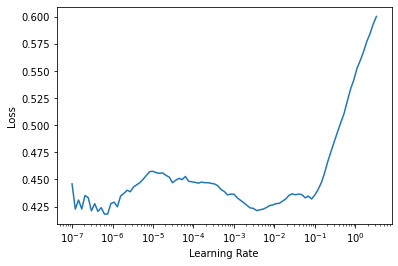

In [23]:
learn.lr_find()

In [24]:
learn.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,time
0,0.040111,0.004141,02:41


epoch,train_loss,valid_loss,time
0,0.006517,0.002241,03:07
1,0.002490,0.000147,03:07
2,0.001767,0.000081,03:06
